# Preprocessing

The data was extracted from Kaggle

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("cancer_data.csv")

In [3]:
df.head(4)

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,1,M,23,12,151,954,0.143,0.278,0.242,0.079
1,2,B,9,13,133,1326,0.143,0.079,0.181,0.057
2,3,M,21,27,130,1203,0.125,0.160,0.207,0.060
3,4,M,14,16,78,386,0.070,0.284,0.260,0.097


In [4]:
df.shape

(100, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 100 non-null    int64  
 1   diagnosis_result   100 non-null    object 
 2   radius             100 non-null    int64  
 3   texture            100 non-null    int64  
 4   perimeter          100 non-null    int64  
 5   area               100 non-null    int64  
 6   smoothness         100 non-null    float64
 7   compactness        100 non-null    float64
 8   symmetry           100 non-null    float64
 9   fractal_dimension  100 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 7.9+ KB


In [6]:
df = df.replace("M", 1)

In [7]:
df = df.replace("B", 0)

In [8]:
df.head(4)

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,1,1,23,12,151,954,0.143,0.278,0.242,0.079
1,2,0,9,13,133,1326,0.143,0.079,0.181,0.057
2,3,1,21,27,130,1203,0.125,0.160,0.207,0.060
3,4,1,14,16,78,386,0.070,0.284,0.260,0.097


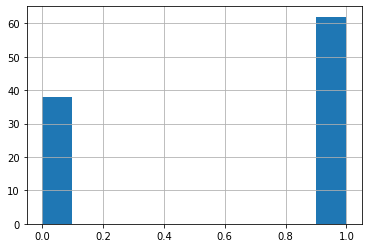

In [9]:
%matplotlib inline
df["diagnosis_result"].hist()

### Splitting data

In [10]:
x = df.drop("diagnosis_result", axis=1)

In [11]:
y = df["diagnosis_result"]

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, stratify=y)

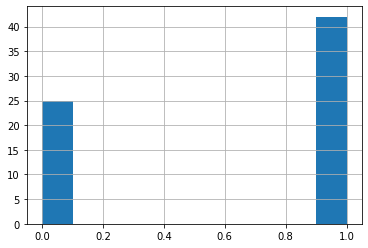

In [13]:
y_train.hist()

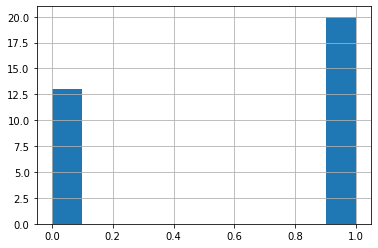

In [14]:
y_test.hist()

In [15]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

In [16]:
x_train = sc.fit_transform(x_train)

In [17]:
x_train = pd.DataFrame(data=x_train[:,1:],    # values
             index=range(0,67), 
              columns=x.columns[1:])
x_train.head(4)

,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,-0.527005,1.776113,0.916088,0.984532,0.906981,0.335983,0.508431,-0.188917
1,-0.949872,0.948290,-0.084639,-0.223148,0.210902,1.148310,0.052496,1.039963
2,-0.104139,1.155246,0.374028,0.279272,0.141294,0.445334,0.215330,0.056859
3,-0.949872,-0.914312,-0.168033,-0.435350,0.767765,1.585717,0.443298,1.531515


In [18]:
x_train.shape

(67, 8)

# Feature selection

### K best

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

In [20]:
selector = SelectKBest(mutual_info_regression, k=4)

In [21]:
selector.fit(x_train, y_train)

SelectKBest(k=4,
            score_func=<function mutual_info_regression at 0x0000021A6B332B88>)

In [22]:
selector.scores_

array([0.        , 0.        , 0.27455323, 0.28901783, 0.        ,
       0.242093  , 0.00137504, 0.11963309])

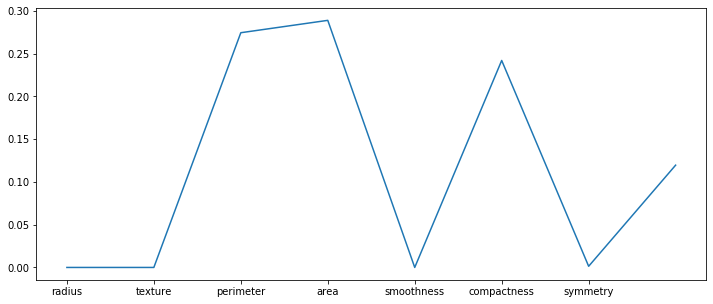

In [23]:
scores = selector.scores_
plt.rcParams["figure.figsize"] = [12,5]
plt.plot(scores)
plt.xticks(np.arange(7),list(x_train.columns));

- Perimeter
- Area
- Compactness
- fractal_dimension

### Ridge CV

In [24]:
from sklearn.linear_model import RidgeCV

In [25]:
crv = RidgeCV(store_cv_values=True)

In [26]:
fit = crv.fit(x_train, y_train)

In [27]:
fit.alpha_

1.0

In [28]:
var = np.floor(np.log10(np.abs(fit.coef_)))

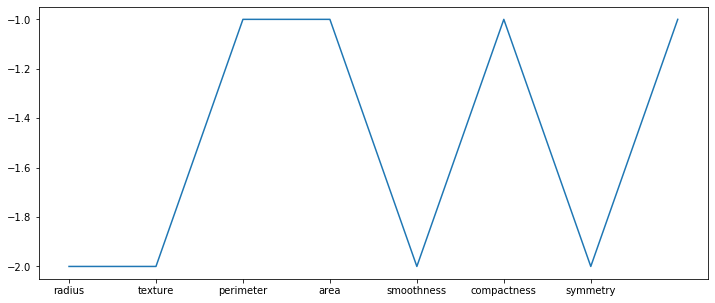

In [29]:
plt.rcParams["figure.figsize"] = [12,5]
plt.plot(var)
plt.xticks(np.arange(7),list(x_train.columns));

- Perimeter
- area
- compactness
- fractal_dimension

### Recursive Feature Elimination (RFE)

It's a backward method of selection, it means that it creates models and removes the features that contribute with less information.

In [30]:
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold  #Test and Train Stratified
from sklearn.feature_selection import RFECV

In [31]:
rfc = RandomForestClassifier(random_state=101)

rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(x_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=101,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [32]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 6


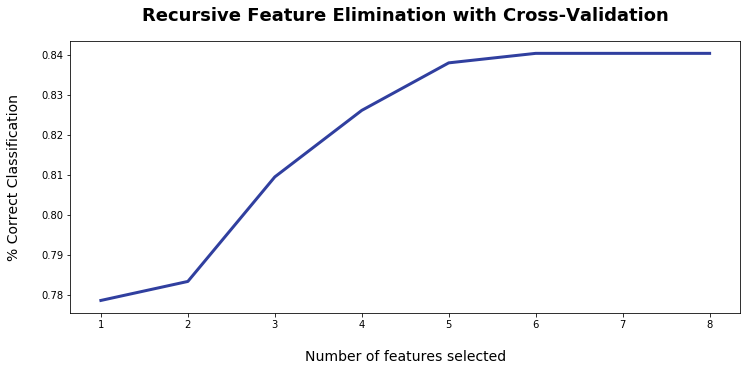

In [33]:
plt.figure(figsize=(12, 5))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

- The performance of choising 3 and 5 variables is almost de same, then we chose 3 to reduce the complexity

In [41]:
for i in range(x_train.shape[1]):
    print('Column: {}, Selected {}, Rank: {}'.format(x_train.columns[i], rfecv.support_[i], rfecv.ranking_[i]))

Column: radius, Selected False, Rank: 2
Column: texture, Selected False, Rank: 3
Column: perimeter, Selected True, Rank: 1
Column: area, Selected True, Rank: 1
Column: smoothness, Selected True, Rank: 1
Column: compactness, Selected True, Rank: 1
Column: symmetry, Selected True, Rank: 1
Column: fractal_dimension, Selected True, Rank: 1


#### Chosen variables are: area, perimeter, compactness and fractal_dimension

In [42]:
x_test, x_train = (x_test[["area", "perimeter", "compactness", "fractal_dimension"]],
                   x_train[["area", "perimeter", "compactness", "fractal_dimension"]])

In [43]:
x_train.corr()

,area,perimeter,compactness,fractal_dimension
area,1.000000,0.971628,0.447421,-0.239045
perimeter,0.971628,1.000000,0.559076,-0.144321
compactness,0.447421,0.559076,1.000000,0.663771
fractal_dimension,-0.239045,-0.144321,0.663771,1.000000


- There is multicolinealitity between area and perimeter, then we delete on of those, in this case we delete perimeter

In [44]:
x_test, x_train = x_test.drop("perimeter", axis=1), x_train.drop("perimeter", axis=1)

# Modeling

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

- Logistic regression

In [46]:
results_1 = cross_validate(LogisticRegression(), x_train, y_train, return_train_score=True, cv=5)

In [51]:
test_scores = results_1['test_score']
train_scores = results_1['train_score']
print(np.mean(train_scores))
print(np.mean(test_scores))

0.8919636617749825
0.8824175824175825


- SVM linear

In [52]:
from sklearn.svm import LinearSVC

In [53]:
results_2 = cross_validate(LinearSVC(), x_train, y_train, return_train_score=True, cv=5)

In [54]:
test_scores = results_2['test_score']
train_scores = results_2['train_score']
print(np.mean(train_scores))
print(np.mean(test_scores))

0.8473794549266248
0.8076923076923078


- SVM poly degree=2

In [55]:
from sklearn.svm import SVC

In [56]:
results_3 = cross_validate(SVC(kernel="poly", degree=2, coef0=1, C=5), x_train, y_train, return_train_score=True, cv=5)

In [57]:
test_scores = results_3['test_score']
train_scores = results_3['train_score']
print(np.mean(train_scores))
print(np.mean(test_scores))

0.903214535290007
0.8824175824175825


- DecisionTree

In [58]:
from sklearn.tree import DecisionTreeClassifier

In [59]:
results_4 = cross_validate(DecisionTreeClassifier(max_depth=3), x_train, y_train, return_train_score=True, cv=5)

In [60]:
test_scores = results_4["test_score"]
train_scores = results_4["train_score"]
print(np.mean(train_scores))
print(np.mean(test_scores))

0.940461215932914
0.7780219780219781


- RandomForest

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
results_5 = cross_validate(RandomForestClassifier(max_leaf_nodes=10), x_train, y_train, return_train_score=True, cv=5)

In [63]:
test_scores = results_5["test_score"]
train_scores = results_5["train_score"]
print(np.mean(train_scores))
print(np.mean(test_scores))

1.0
0.8241758241758241


- AdaBoost

In [64]:
from sklearn.ensemble import AdaBoostClassifier

In [65]:
results_6 = cross_validate(AdaBoostClassifier(DecisionTreeClassifier(max_leaf_nodes=10),
                                              n_estimators=500, algorithm="SAMME.R",
                                              learning_rate=0.1), x_train, y_train, return_train_score=True, cv=5)

In [66]:
test_scores = results_6["test_score"]
train_scores = results_6["train_score"]
print(np.mean(train_scores))
print(np.mean(test_scores))

1.0
0.7791208791208792


- GradientBoosting

In [67]:
from sklearn.ensemble import GradientBoostingClassifier

results_7 = cross_validate(GradientBoostingClassifier(max_depth=3, n_estimators=40, learning_rate=0.01), x_train, y_train,
                      return_train_score=True, cv=5)

In [68]:
test_scores = results_7["test_score"]
train_scores = results_7["train_score"]
print(np.mean(train_scores))
print(np.mean(test_scores))

0.9255765199161425
0.8087912087912088


## Hyperparameter's optimization

### LogisticRegression

In [93]:
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix

In [71]:
params = {"C": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

In [73]:
estimator = LogisticRegression()

In [74]:
ggrid = GridSearchCV(estimator, 
                     param_grid = params,
                     scoring="precision",
                     cv=5
                    )

In [75]:
final_model = ggrid.fit(x_train, y_train)

In [76]:
ggrid.cv_results_, ggrid.best_params_, ggrid.best_score_

({'mean_fit_time': array([0.00876656, 0.00832453, 0.00639281, 0.00371699, 0.        ,
         0.        , 0.00625124, 0.        , 0.00623507, 0.00937395]),
  'std_fit_time': array([0.00138637, 0.00039891, 0.00590861, 0.00743399, 0.        ,
         0.        , 0.00765617, 0.        , 0.00763641, 0.0076538 ]),
  'mean_score_time': array([0.00010014, 0.00170259, 0.        , 0.00312028, 0.00937381,
         0.00630121, 0.        , 0.0062469 , 0.        , 0.        ]),
  'std_score_time': array([0.00020027, 0.00340519, 0.        , 0.00624056, 0.00765369,
         0.00771739, 0.        , 0.00765087, 0.        , 0.        ]),
  'param_C': masked_array(data=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'C': 0.1},
   {'C': 0.2},
   {'C': 0.3},
   {'C': 0.4},
   {'C': 0.5},
   {'C': 0.6},
   {'C': 0.7},
   {'C'

In [79]:
final_results = cross_validate(ggrid.best_estimator_, x_train, y_train, return_train_score=True, cv=5, scoring="precision")

In [80]:
test_scores = final_results["test_score"]
train_scores = final_results["train_score"]
print(np.mean(train_scores))
print(np.mean(test_scores))

0.894810483634013
0.9164141414141416


In [84]:
final_estimator = LogisticRegression(C=1.0)

In [86]:
final_estimator.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [92]:
predicte = final_estimator.predict(x_test)

In [95]:
print(final_estimator.score(x_test, y_test), recall_score(y_test, predicte), precision_score(y_test, predicte))

0.6060606060606061 1.0 0.6060606060606061


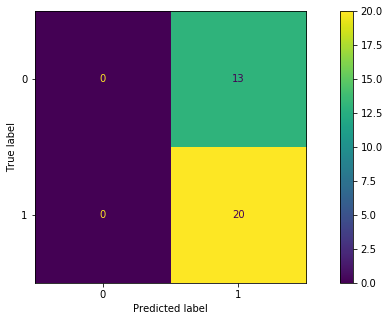

In [103]:
plot_confusion_matrix(final_estimator, x_test, y_test)  
plt.show()  

## The model is able to diagnose cancer to the people that really have cancer, but there is a problem because all the people that have not cancer also were diagnosed with cancer. It is due probably because there is not enough information about every class, so it is needed to collect more data and enrich the model